```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

Producing plots of data assimilation experiments by post-processing the
files produced by scripts/run_experiment.py

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Forecast Error evaluation

## Set environment

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc

import os
import sys
import datetime

from importlib import reload
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Import our simulator
from SWESimulators import IPythonMagic, SimReader, Observation, ParticleInfo
from SWESimulators import DataAssimilationUtils as dautils

In [2]:
%cuda_context_handler gpu_ctx
timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")


In [3]:
#Create output directory for images
#imgdir = 'double_jet'
#filename_prefix = imgdir + "/" + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S") + "_"
#os.makedirs(imgdir, exist_ok=True)
#print("Saving images to " + imgdir)

### Define functions for plotting

## Specify the folder containing the results

In [4]:
#result_dir = os.path.abspath('scripts/da_experiment_2019_05_06-14_35_19_IEWPF2s_success/')
result_dirs = [os.path.abspath('/media/havahol/Seagate Backup Plus Drive/gpu_ocean/june_25_truth/all_forecasts_2019_06_25-13_13_46/' + \
                             'da_experiment_2019_06_25-13_13_48-dry_run'),
               os.path.abspath('/media/havahol/Seagate Backup Plus Drive/gpu_ocean/june_25_truth/all_forecasts_2019_06_25-13_13_46/' + \
                             'da_experiment_2019_06_25-14_35_13-10drifters'),
               os.path.abspath('/media/havahol/Seagate Backup Plus Drive/gpu_ocean/june_25_truth/all_forecasts_2019_06_25-13_13_46/' + \
                             'da_experiment_2019_06_25-16_05_17-alldrifters'),
               os.path.abspath('/media/havahol/Seagate Backup Plus Drive/gpu_ocean/june_25_truth/all_forecasts_2019_06_25-13_13_46/' + \
                             'da_experiment_2019_06_25-17_59_44-all-buoys'),
               os.path.abspath('/media/havahol/Seagate Backup Plus Drive/gpu_ocean/june_25_truth/all_forecasts_2019_06_25-13_13_46/' + \
                             'da_experiment_2019_06_25-21_08_44-western_buoys'),
               os.path.abspath('/media/havahol/Seagate Backup Plus Drive/gpu_ocean/june_25_truth/all_forecasts_2019_06_25-13_13_46/' + \
                             'da_experiment_2019_06_25-23_25_47-southern_buoys')
              ]
print(result_dirs)

labels = ["No DA",
          "10 drifters",
          "All drifters",
          "All buoys",
          "Western buoys",
          "Southern buoys"         
         ]


#truth_folder = "double_jet_truth"
truth_folder = os.path.join(result_dirs[0], "truth")

drifterSet = [ 2,  7, 12, 24, 29, 35, 41, 48, 53, 60]


['/media/havahol/Seagate Backup Plus Drive/gpu_ocean/june_25_truth/all_forecasts_2019_06_25-13_13_46/da_experiment_2019_06_25-13_13_48-dry_run', '/media/havahol/Seagate Backup Plus Drive/gpu_ocean/june_25_truth/all_forecasts_2019_06_25-13_13_46/da_experiment_2019_06_25-14_35_13-10drifters', '/media/havahol/Seagate Backup Plus Drive/gpu_ocean/june_25_truth/all_forecasts_2019_06_25-13_13_46/da_experiment_2019_06_25-16_05_17-alldrifters', '/media/havahol/Seagate Backup Plus Drive/gpu_ocean/june_25_truth/all_forecasts_2019_06_25-13_13_46/da_experiment_2019_06_25-17_59_44-all-buoys', '/media/havahol/Seagate Backup Plus Drive/gpu_ocean/june_25_truth/all_forecasts_2019_06_25-13_13_46/da_experiment_2019_06_25-21_08_44-western_buoys', '/media/havahol/Seagate Backup Plus Drive/gpu_ocean/june_25_truth/all_forecasts_2019_06_25-13_13_46/da_experiment_2019_06_25-23_25_47-southern_buoys']


In [14]:
def file_filter(path_to_dir, ext=None, prefix=None, abspath=True):
    filtered_files = os.listdir(path_to_dir)
    if prefix:
        filtered_files = list(file for file in filtered_files if file.startswith(prefix))
    if ext:
        filtered_files = list(file for file in filtered_files if file.endswith(ext))
    if abspath:
        filtered_files= list(os.path.join(path_to_dir, file)  for file in filtered_files)

    filtered_files.sort()
    return filtered_files


nc_files = [None]*6
obs_files = [None]*6
particle_info_files = [None]*6

for i in range(6):
    nc_files[i] = file_filter(result_dirs[i], ext='nc')
    obs_files[i] = file_filter(result_dirs[i], ext='bz2', prefix='forecast')
    particle_info_files[i] = file_filter(result_dirs[i], ext='bz2', prefix='particle_info')
    print("number of nc_files:            ", len(nc_files[i]))
    print("number of obs_files:           ", len(obs_files[i]))
    print("number of particle_info_files: ", len(particle_info_files[i]))

if False:
    print(len(nc_files), nc_files)
    print()
    print(len(obs_files), obs_files)
    print()
    print(len(particle_info_files), particle_info_files)
    
# Truth:
true_nc = truth_folder + "/double_jet_case_truth.nc"
true_obs_file = truth_folder + "/drifter_observations.pickle"
    
ensemble_size = len(nc_files)
num_drifters=64

drifterSet = [ 2,  7, 12, 24, 29, 35, 41, 48, 53, 60]



number of nc_files:             100
number of obs_files:            100
number of particle_info_files:  700
number of nc_files:             100
number of obs_files:            98
number of particle_info_files:  700
number of nc_files:             100
number of obs_files:            100
number of particle_info_files:  700
number of nc_files:             100
number of obs_files:            99
number of particle_info_files:  700
number of nc_files:             100
number of obs_files:            97
number of particle_info_files:  700
number of nc_files:             100
number of obs_files:            98
number of particle_info_files:  700


In [16]:
# Read netCDF files
reload(SimReader)

truth_reader = SimReader.SimNetCDFReader(true_nc)

equilibrium_depth = truth_reader.getH()[0,0]
nx = truth_reader.get('nx')
ny = truth_reader.get('ny')
domain_size_x = nx*truth_reader.get('dx')
domain_size_y = ny*truth_reader.get('dy')

### Functions for plotting

In [9]:
def imshow(im, interpolation="None", title=None, figsize=(4,4), interior=False):
    fig = plt.figure(figsize=figsize)
    
    if interior:
        im = plt.imshow(im[2:-2,2:-2], interpolation=interpolation, origin='lower')
    else:
        im = plt.imshow(im, interpolation=interpolation, origin='lower')
    
    plt.colorbar()
    if title is not None:
        plt.title(title)
        
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(14,2.8), 
            color_bar_from_zero=False, save_filename=None, constant_range=False):
    
    fig, axs = plt.subplots(1,3, figsize=figsize)
    
    eta_max = np.max(np.abs(eta))
    huv_max = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    
    if constant_range:
        eta_max = 3.5
        huv_max = 600
    
    eta_min = -eta_max
    huv_min = -huv_max
    if color_bar_from_zero:
        eta_min, huv_min = 0, 0
        
    nx = truth_reader.get('nx')
    ny = truth_reader.get('ny')
    dx = truth_reader.get('dx')
    dy = truth_reader.get('dy')
    extent=np.array([0, nx*dx, 0, ny*dy]) / 1000
    
    
    eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', 
                           vmin=eta_min, vmax=eta_max, extent=extent)
    axs[0].set_title("$\eta$ [m]")
    cbar_eta = plt.colorbar(eta_im, ax=axs[0])
    #cbar_eta.set_label('$\eta$ [m]')#,size=18)
    
    hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', 
                          vmin=huv_min, vmax=huv_max, extent=extent)
    axs[1].set_title("$hu$ [m$^2$/s]")
    plt.colorbar(hu_im, ax=axs[1])
    
    hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower',
                          vmin=huv_min, vmax=huv_max, extent=extent)
    axs[2].set_title("$hv$ [m$^2$/s]")
    plt.colorbar(hv_im, ax=axs[2])
    
    for ax in axs:
        ax.set_xlabel("$x$ [km]")
        ax.set_ylabel("$y$ [km]")
    
    if title is not None:
        plt.suptitle(title, y=1.0)
    plt.tight_layout()
    
    if save_filename is not None:
        fig.savefig(result_dir + "/" + save_filename + ".png")
        fig.savefig(result_dir + "/" + save_filename + ".pdf")
        
        
    
def days_to_sec(days):
    return days*24*60*60

def sec_to_days(secs):
    return secs/(24*60*60)

def truth_time_step(t):
    t = t - days_to_sec(3)
    return int(t/(60*60))

# Forecast errors

First, let the error in the ensemble forecast for drifter $d$ at time $t^n$ be defined as 
$$    E_{d}(t_n) = \sqrt{ \frac{ \sum_{i=1}^{N_e} \left( x_{i,d}^n - x_{true, d}^n \right)^2 + \left(y_{i,d}^n - y_{true, d}^n \right)^2 } {N_e}}.$$
Further, let the forecast error be the mean of $E_d^n$ over all drifters,
$$    E(t_n) = \frac{1}{N_D} \sum_{d=1}^{N_D} E_d(t^n).$$

In [21]:
reload(Observation)

start_time_forecast = days_to_sec(10)
end_time_forecast = days_to_sec(13)

# Read truth observation file:
true_observations = Observation.Observation(domain_size_x=domain_size_x, 
                                            domain_size_y=domain_size_y, 
                                            nx=nx, ny=ny)
true_observations.read_pickle(true_obs_file)

# Read observation files from the ensemble:
obs_files_buoys = obs_files[3]


ensemble_observations = [None]*len(obs_files_buoys)
for i in range(len(obs_files_buoys)):
    ensemble_observations[i] = Observation.Observation(domain_size_x=domain_size_x, 
                                                       domain_size_y=domain_size_y, 
                                                       nx=nx, ny=ny)
    ensemble_observations[i].read_pickle(obs_files_buoys[i])
    print("."+str(i)+".", end='')

.0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97..98.

In [70]:
# Aim for a time resolution of one per hour
drifter_id = 1

def getForecastError(ensemble_observations, drifter_id):
    """
    returns the forecast errors per hour for the given drifter and ensemble
    """
    forecast_paths = [None]*len(ensemble_observations)
    for i in range(len(forecast_paths)):
        forecast_paths[i] = ensemble_observations[i].get_drifter_path(drifter_id,  
                                                                      start_time_forecast,
                                                                      end_time_forecast,
                                                                      keepDomainSize=False)
        # Only one path per forecast, as we do not keep the domain size
        # we therefore simplify the data structure, and filter for every hour only
        # Starting at hour 1
        forecast_paths[i] = forecast_paths[i][0][11::12,:]

    
    # And read the true path
    true_path = true_observations.get_drifter_path(drifter_id,  
                                                   start_time_forecast,
                                                   end_time_forecast,
                                                   keepDomainSize=False)
    # Only one path per forecast, as we do not keep the domain size
    # we therefore simplify the data structure, and filter for every hour only
    # Starting at hour 1
    true_path = true_path[0][11::12,:]
    
    drifter_error = np.zeros(72)
    active_ensemble_size = len(forecast_paths)
    for t in range(72):
        for i in range(active_ensemble_size):
            drifter_error[t] += (forecast_paths[i][t,0] - true_path[t,0])**2 + (forecast_paths[i][t,1] - true_path[t,1])**2
        drifter_error[t] = np.sqrt(drifter_error[t]/active_ensemble_size)
    return drifter_error

In [71]:
def forecastErrorMean(ensemble_observations, drifterSet=None):
    drifter_error_means = np.zeros(72)
    if drifterSet is None:
        drifterSet = list(range(num_drifters))
        
    print("obtaining forecastErrorMean")
    for drifter in drifterSet:
        drifter_error_means += getForecastError(ensemble_observations, drifter)
        print("."+str(drifter)+".", end='')
        
    drifter_error_means /= len(drifterSet)
    return drifter_error_means
    


In [72]:
def forecastMeanForFileSet(fileSet, drifterSet=None):
    """
    fileSet is observationFiles
    """
    
    ensemble_observations = [None]*len(fileSet)
    print('reading fileSet')
    for i in range(len(fileSet)):
        ensemble_observations[i] = Observation.Observation(domain_size_x=domain_size_x, 
                                                           domain_size_y=domain_size_y, 
                                                           nx=nx, ny=ny)
        ensemble_observations[i].read_pickle(fileSet[i])
        print("."+str(i)+".", end='')
        
    return forecastErrorMean(ensemble_observations, drifterSet=drifterSet)

In [74]:
### Obtain forecastErrorMeans from all experiments

forecast_errors_drifter_sets = [None]*6
for i in range(6):
    print(labels[i])
    forecast_errors_drifter_sets[i] = forecastMeanForFileSet(obs_files[i], drifterSet=drifterSet)


No DA
reading fileSet
.0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97..98..99.obtaining forecastErrorMean
.2..7..12..24..29..35..41..48..53..60.10 drifters
reading fileSet
.0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97.obtaining forecastErrorMean
.2..7..12..24..29..35..41..48..53..60.All drifters
reading fileSet
.0..1..2..3..4..5

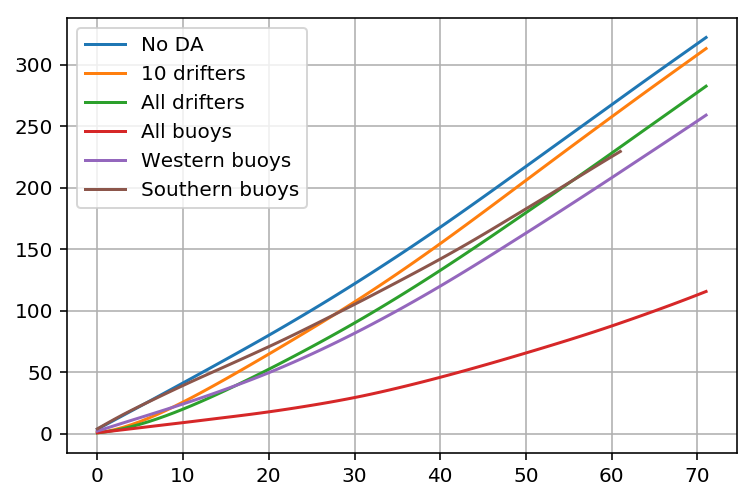

In [77]:

fig = plt.figure()
for i in range(6):
    plt.plot(forecast_errors_drifter_sets[i], label=labels[i])
plt.legend()
plt.grid()

In [ ]:
### Obtain forecastErrorMeans from all experiments

forecast_error_means = [None]*6
for i in range(6):
    print(labels[i])
    forecast_error_means[i] = forecastMeanForFileSet(obs_files[i])


No DA
reading fileSet
.0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97..98..99.obtaining forecastErrorMean
.0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63.10 drifters
reading fileSet
.0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73.

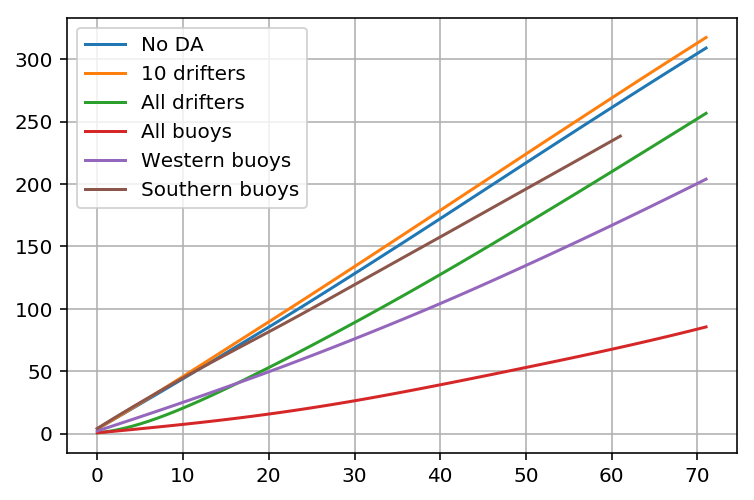

In [83]:

fig = plt.figure()
for i in range(6):
    plt.plot(forecast_error_means[i], label=labels[i])
plt.legend()
plt.grid()

In [66]:
drifter_error_1 = getForecastError(ensemble_observations, 1)
drifter_error_2 = getForecastError(ensemble_observations, 2)
drifter_error_3 = getForecastError(ensemble_observations, 3)
mean_error = forecastErrorMean(ensemble_observations)
mean_error_drifter_set = forecastErrorMean(ensemble_observations, drifterSet=drifterSet)


obtaining forecastErrorMean
.0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63.obtaining forecastErrorMean
.2..7..12..24..29..35..41..48..53..60.

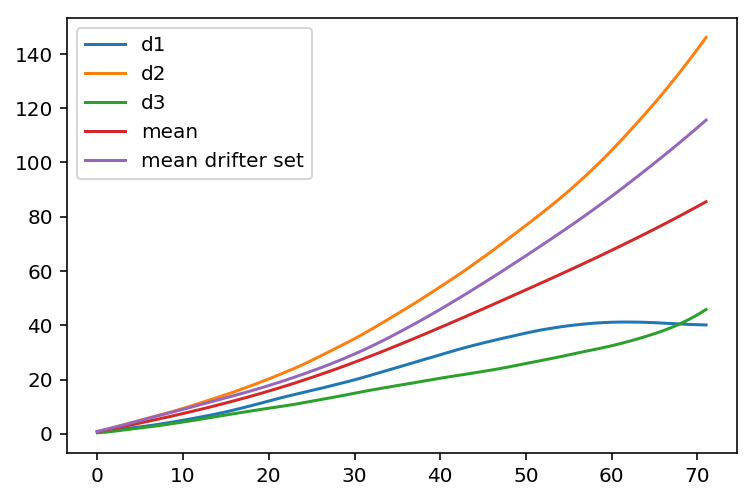

In [67]:
fig = plt.figure(figsize=)
plt.plot(drifter_error_1, label='d1')
plt.plot(drifter_error_2, label='d2')
plt.plot(drifter_error_3, label='d3')
plt.plot(mean_error, label='mean')
plt.plot(mean_error_drifter_set, label='mean drifter set')
plt.legend()